# Sentinel-1 and Sentinel-2

Free and Open Data Policy: [scihub](https://scihub.copernicus.eu/)

## [Sentinel-1](https://en.wikipedia.org/wiki/Sentinel-1)

* A constellation of two satellites, Sentinel-1A and Sentinel-1B
* C-band synthetic-aperture radar (SAR)
* Collection of data in all-weather, day or night
* Spatial resolution of down to 5 m and a swath of up to 400 km
* Sun synchronous, near-polar (98.18°) orbit
* The orbit has a 12-day repeat cycle

## [Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2)

* A constallation of two twin satellites, Sentinel-2A and Sentinel-2B
* Multi-spectral data with 13 bands in the visible, near infrared, and short wave infrared part of the spectrum
* Systematic global coverage of land surfaces from 56° S to 84° N, coastal waters, and all of the Mediterranean Sea
* High spatial resolution (10 m to 60 m). 290 km field of view
* The orbit is Sun synchronous at 786 km (488 mi) altitude
* Revisiting every 10 days under the same viewing angles. At high latitudes, Sentinel-2 swath overlap and some regions will be observed twice or more every 10 days, but with different viewing angles

## Example Search and preview a Sentinel-1 and Sentinel-2 image

TODO: eodag or sentinelsat or ciop search?

## How does SAR work?
SAR is a Radar: a beam of energy is emitted from an antenna. As they strike objects the energy is scattered in all directions with some of the energy reflected directly back to the radar. 

Synthetic Aperture Radar: uses the motion of the radar antenna over a target region to provide finer spatial resolution than conventional beam-scanning radars.

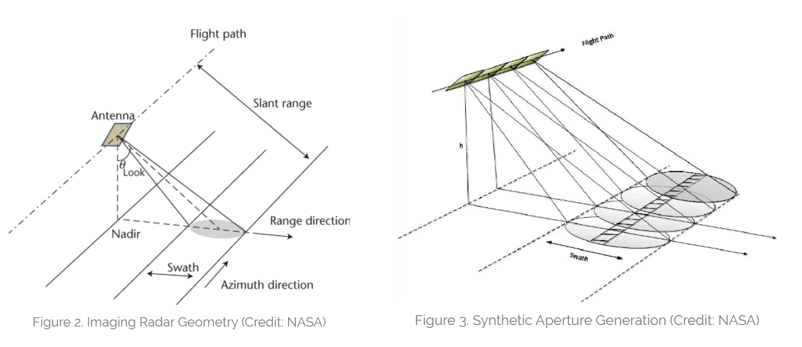

Images are not very intuitive because we are not used to see them. They have geometric distortions and the pixel value is completely different to what we see with our eyes (or with optical sensors).

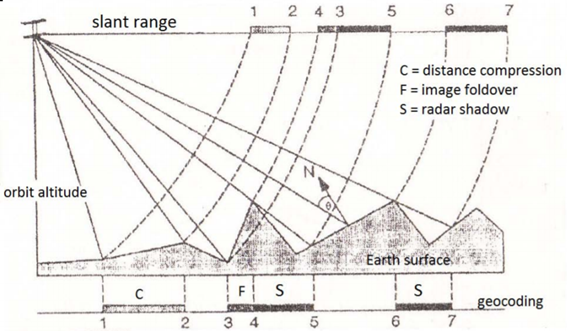

The pixel values are proportional to the amount of energy received and it depends on the amount of energy the SAR sensor transmitted, the properties and shape of the object and the angle from which the object is viewed.

## SAR image example 

TODO: simple interpretation example:

-  e.g. foreshortening and layover
-  cloudy example S1 vs S2


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
fpT2= 'https://store.terradue.com/obarrilero/_results/workflows/ec_nextgeoss_ewf_s2_mad_ewf_s2_mad_0_11/run/5d6083d2-0888-11eb-9d01-0242ac11000d/0078863-200713102632727-oozie-oozi-W/ae2e971f-c8c5-447a-aefc-7e78729bfdd7/cd_L2A_T50RKU_A012499_20190729T025903_L2A_T50RKU_A024768_20200320T030130.tif'
# Open the COG
with rasterio.open(fp) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve the smallest thumbnail
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
from helpers import *
fpT2= 'https://store.terradue.com/obarrilero/_results/workflows/ec_nextgeoss_ewf_s2_mad_ewf_s2_mad_0_11/run/5d6083d2-0888-11eb-9d01-0242ac11000d/0078863-200713102632727-oozie-oozi-W/ae2e971f-c8c5-447a-aefc-7e78729bfdd7/cd_L2A_T50RKU_A012499_20190729T025903_L2A_T50RKU_A024768_20200320T030130.tif'
aoi_bbox = '114,30.50,114.2,30.55'
aoi = [float(coord) for coord in aoi_bbox.split(',')]
user='YOURuser'
api_key='YOURkey'
img_data = vsi_download(fpT2, aoi, user, api_key)

In [ ]:
print(img_data.shape)

fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1, 1, 1)
a.set_title('titulo')
width = 12
height = 12
data = img_data
    
imgplot = plt.imshow(data.reshape(data.shape[0],data.shape[1]), cmap=plt.cm.gray) #, vmin=-5, vmax=15)

plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()